# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev1 toc-item"><a href="#Build-Graph" data-toc-modified-id="Build-Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build Graph</a></div><div class="lev1 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev1 toc-item"><a href="#Train" data-toc-modified-id="Train-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train</a></div><div class="lev1 toc-item"><a href="#Predict" data-toc-modified-id="Predict-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict</a></div>

- **Neural Causal Reasoning Model**

# Load Data

In [137]:
import pickle
import h5py

In [138]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/index.pkl', 'rb') as fp:
    word2index, index2word = pickle.load(fp)

with h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:] 

with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/zTrian/data/train.pkl', 'rb') as fp:
    xc, xe, s  = pickle.load(fp)

In [141]:
dc1 = [list(set([word2index[i[0]] for i in cp])) for cp in devcp1]; dc1 = [np.array([i]) for i in dc1]
de1 = [list(set([word2index[i[1]] for i in cp])) for cp in devcp1]; de1 = [np.array([i]) for i in de1]
dc2 = [list(set([word2index[i[0]] for i in cp])) for cp in devcp2]; dc2 = [np.array([i]) for i in dc2]
de2 = [list(set([word2index[i[1]] for i in cp])) for cp in devcp2]; de2 = [np.array([i]) for i in de2]
tc1 = [list(set([word2index[i[0]] for i in cp])) for cp in testcp1]; tc1 = [np.array([i]) for i in tc1]
te1 = [list(set([word2index[i[1]] for i in cp])) for cp in testcp1]; te1 = [np.array([i]) for i in te1]
tc2 = [list(set([word2index[i[0]] for i in cp])) for cp in testcp2]; tc2 = [np.array([i]) for i in tc2]
te2 = [list(set([word2index[i[1]] for i in cp])) for cp in testcp2]; te2 = [np.array([i]) for i in te2]

# Import Libraries

In [9]:
from keras.layers import Input, Embedding, Lambda, Dense, Dropout, Flatten, dot
from keras.layers.noise import AlphaDropout
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Build Graph

In [37]:
def ncrm(glove=True, tune=False, num_layer=2, hidden_size=300, hidden_activation='relu', dropout_rate=0.2, seed=42, output_activation=None, loss='mse', optimizer='adam'):
    """
    Hyperparameters
    ----------
    :param glove: use glove embedding or not 
    :param tune: tune embedding parameters or not
    :param num_layer: number of hidden layer
    :param hidden_size: sizes of hidden layer
    :param dropout_rate: dropout layer rate
    :param hidden_activation: activation function of hidden layer
    :param seed: random seed
    :param output_activation: activation function of output layer
    :param loss: loss function
    :param optimizer: optimize method
    
    Returns
    ----------
    Neural Causal Reasoning Model.
    """
    def swish(x):
        return x * K.sigmoid(x)
    if hidden_activation == 'swish':
        hidden_activation = swish
    cw = Input(shape=(None,), name='CAUSE')
    if glove == False:
        cw_emb = Embedding(input_dim=2793,
                           output_dim=300,
                           name='CW_EMBEDDING')(cw)
    else:
        cw_emb = Embedding(input_dim=2793,
                           output_dim=300,
                           weights=[embedding],
                           trainable=tune,
                           name='CW_EMBEDDING')(cw)
    dense = Lambda(lambda x: K.sum(x, axis=1), name='CW_SUM')(cw_emb)
    for l in range(num_layer-1):
        dense = Dense(hidden_size, activation=hidden_activation, name='HIDDEN_%d' % (l+1))(dense)
        if hidden_activation == 'selu':
            dense = AlphaDropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (l+1))(dense)
        else:
            dense = Dropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (l+1))(dense)
    dense = Dense(300, activation=hidden_activation, name='HIDDEN_%d' % (num_layer))(dense)
    if hidden_activation == 'selu':
        dense = AlphaDropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (num_layer))(dense)
    else:
        dense = Dropout(dropout_rate, seed=seed, name='DROPOUT_%d' % (num_layer))(dense)
    ew = Input(shape=(None,), name='EFFECT')
    if glove == False:
        ew_emb = Embedding(input_dim=2793,
                           output_dim=300,
                           name='EW_EMBEDDING')(ew)
    else:
        ew_emb = Embedding(input_dim=2793,
                           output_dim=300,
                           weights=[embedding],
                           trainable=tune,
                           name='EW_EMBEDDING')(ew)
    ew_emb = Lambda(lambda x: K.sum(x, axis=1), name='EW_SUM')(ew_emb)
    output = dot([dense, ew_emb], axes=-1, normalize=False, name='REASONING')
    output = Dense(1, activation=output_activation, name='OUTPUT')(output)
    model = Model(inputs=[cw, ew], outputs=output)
    model.compile(loss=loss, optimizer=optimizer)
    return model

# Model Visualization

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
CAUSE (InputLayer)               (None, None)          0                                            
____________________________________________________________________________________________________
CW_EMBEDDING (Embedding)         (None, None, 300)     837900      CAUSE[0][0]                      
____________________________________________________________________________________________________
CW_SUM (Lambda)                  (None, 300)           0           CW_EMBEDDING[0][0]               
____________________________________________________________________________________________________
HIDDEN_1 (Dense)                 (None, 300)           90300       CW_SUM[0][0]                     
___________________________________________________________________________________________

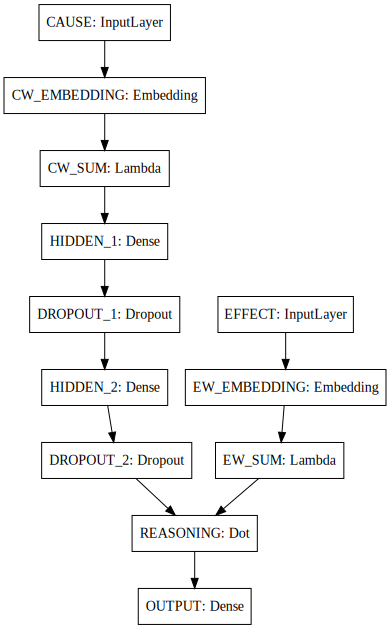

In [41]:
NCRM = ncrm(glove=True, tune=False, num_layer=2, hidden_size=300, hidden_activation='relu', dropout_rate=0.2, seed=42, output_activation=None, loss='mse', optimizer='adam')
NCRM.summary()
SVG(model_to_dot(NCRM).create(prog='dot', format='svg'))

# Train

In [128]:
PC = ('True-False-3-300-relu-0.2-42-None-mse-adam')

GLOVE = True if PC.split('-')[0] == 'True' else False
TUNE = True if PC.split('-')[1] == 'True' else False
NUM_LAYERS = int(PC.split('-')[2])
HIDDEN_SIZE = int(PC.split('-')[3])
HIDDEN_ACTIVATION = PC.split('-')[4]
DROPOUT_RATE = float(PC.split('-')[5])
SEED = int(PC.split('-')[6])
OUTPUT_ACTIVATION = None if PC.split('-')[7] == 'None' else PC.split('-')[7]
LOSS = PC.split('-')[8]
OPTIMIZER = PC.split('-')[9]

print("——————Hyperparameter Configuration——————")
print("----------------------------------------")
print("Using GLove Embedding: \t\t%s" % GLOVE)
if GLOVE == True:
    print("Tuning Embedding: \t\t%s" % TUNE)
print("Number of Dense Layers: \t%d" % NUM_LAYERS)
print("Hidden Layer Size: \t\t%d" % HIDDEN_SIZE)
print("Hidden Layer Activation: \t%s" % HIDDEN_ACTIVATION)
print("Dropout Rate: \t\t\t%.1f" % DROPOUT_RATE)
print("Random Seed: \t\t\t%d" % SEED)
print("Output Layer Activation: \t%s" % OUTPUT_ACTIVATION)
print("Loss Function: \t\t\t%s" % LOSS)
print("Optimize Method: \t\t%s" % OPTIMIZER)

——————Hyperparameter Configuration——————
----------------------------------------
Using GLove Embedding: 		True
Tuning Embedding: 		False
Number of Dense Layers: 	3
Hidden Layer Size: 		300
Hidden Layer Activation: 	relu
Dropout Rate: 			0.2
Random Seed: 			42
Output Layer Activation: 	None
Loss Function: 			mse
Optimize Method: 		adam


In [129]:
filepath = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/zTrain/cp_logs/relu+none/weights.{epoch:03d}-{loss:.6f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
log_string = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/zTrain/tb_logs/relu+none'
tensorboard = TensorBoard(log_dir=log_string)
callbacks_list = [checkpoint, tensorboard]

In [133]:
NCRM = ncrm(glove=GLOVE,
            tune=TUNE,
            num_layer=NUM_LAYERS, 
            hidden_size=HIDDEN_SIZE, 
            hidden_activation=HIDDEN_ACTIVATION, 
            dropout_rate=DROPOUT_RATE, 
            seed=SEED, 
            output_activation=OUTPUT_ACTIVATION, 
            loss=LOSS, 
            optimizer=OPTIMIZER)

In [134]:
BATCH_SIZE = 1024
NUM_EPOCHS = 64

In [ ]:
history = NCRM.fit([xc, xe],
                   s,
                   batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS,
                   verbose=1,
                   callbacks=callbacks_list,
                   shuffle=True)

# Predict

In [ ]:
import pickle

In [140]:
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/copa.pkl', 'rb') as fp:
    _, _, _, _, devcp1, devcp2, devLabel, testcp1, testcp2, testLabel = pickle.load(fp)
    
with open('/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/index.pkl', 'rb') as fp:
    word2index, index2word = pickle.load(fp)

In [ ]:
NUM_LAYERS = 2
HIDDEN_SIZE = 300
HIDDEN_ACTIVATION = 'selu'
DROPOUT_RATE = 0.2
SEED = 42
OUTPUT_ACTIVATION = 'sigmoid'
LOSS = 'mse'
OPTIMIZER = 'adam'

In [ ]:
NCRM = ncrm(num_layer=NUM_LAYERS, 
            hidden_size=HIDDEN_SIZE, 
            hidden_activation=HIDDEN_ACTIVATION, 
            dropout_rate=DROPOUT_RATE, 
            seed=SEED, 
            output_activation=OUTPUT_ACTIVATION, 
            loss=LOSS, 
            optimizer=OPTIMIZER)

In [ ]:
filename = '/Users/lizhn7/Downloads/EXPERIMENT/COPA/FINAL/CausalNet/train/cp_logs/600+3/weights.141-0.611091.hdf5'
NCRM.load_weights(filename)

In [ ]:
def CPMI(pairs, length=None, sp_score=False):
    """
    Compute causal-PMI score
    """
    score = []
    if length == None:
        length = len(pairs)
    for p in pairs:
        c = np.array([word2index[p[0]]])
        e = np.array([word2index[p[1]]])
        CS = NCRM.predict([c, e])[0][0]
        score.append(CS)
    if not sp_score:
        try:
            return sum(score) / length
        except:
            return 0
    else:
        return score

def accuracy(a1, a2, actu, length_mode=2016, show=True):
    """
    Calculate Accuracy
    """
    if length_mode == 2016:
        l1 = [len(set([i[0] for i in a1[n]]+[i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]+[i[-1] for i in a2[n]])) for n in range(500)]
        A1 = [CPMI(a1[i], length=l1[i]) for i in range(500)]
        A2 = [CPMI(a2[i], length=l2[i]) for i in range(500)]
    elif length_mode == 2017:
        A1 = [CPMI(p) for p in a1]
        A2 = [CPMI(p) for p in a2]
    pred = []
    for i in range(500):
        if A1[i] >= A2[i]:
            pred.append(1)
        elif A1[i] < A2[i]:
            pred.append(2)
        else:
            pred.append(0)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    print('Accuracy: \t%.9f' % (ACC))
    if show:
        error = []
        l1 = [len(set([i[0] for i in a1[n]]))+len(set([i[-1] for i in a1[n]])) for n in range(500)]
        l2 = [len(set([i[0] for i in a2[n]]))+len(set([i[-1] for i in a2[n]])) for n in range(500)]
        for i in range(500):
            s1 = []
            s2 = []
            print('————————————————————————————————————')
            print(str(i+1)+':')
            for p in a1[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s1.append(CPMI([p], sp_score=True))
            print('------------------')
            for p in a2[i]:
                print(p[0], p[1], CPMI([p], sp_score=True)[0])
                s2.append(CPMI([p], sp_score=True))
            if length_mode == 2016:
                try:
                    S1 = sum(sum(s1, []))/l1[i]
                except:
                    S1 = 0
                try:
                    S2 = sum(sum(s2, []))/l2[i]
                except:
                    S2 = 0
            elif length_mode == 2017:
                S1 = sum(sum(s1, []))/len(a1[i])
                S2 = sum(sum(s2, []))/len(a2[i])
            print('S1:------'+str(S1))
            print('S2:------'+str(S2))
            if S1 >= S2:
                pre = '1'
            elif S1 < S2:
                pre = '2'
            else:
                pre = '0'
            print('Predict Answer: '+pre)
            print('Correct Answer: '+str(actu[i]))
            if pre != str(actu[i]):
                error.append(i+1)
        return pred, error
    else:
        return pred

In [ ]:
p, e = accuracy(devcp1, devcp2, devLabel, length_mode=2017)

In [ ]:
p, e = accuracy(testcp1, testcp2, testLabel, length_mode=2017)